# Homework 3 Solutions

**Name**:

**ID**:

> **Due Date**
>
> Friday, 3/22/24, 9:00pm

## Overview

### Instructions

The goal of this homework assignment is to practice developing and
working with probability models for data.

### Learning Outcomes

After completing this assignments, students will be able to:

-   develop probability models for data and model residuals under a
    variety of statistical assumptions;
-   evaluate the appropriateness of those assumptions through the use of
    qualitative and quantitative evaluations of goodness-of-fit;
-   fit a basic Bayesian model to data.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

The following packages are included in the environment (to help you find
other similar packages in other languages). The code below loads these
packages for use in the subsequent notebook (the desired functionality
for each package is commented next to the package).

In [2]:
using Random # random number generation and seed-setting
using DataFrames # tabular data structure
using DataFramesMeta # API which can simplify chains of DataFrames transformations
using CSVFiles # reads/writes .csv files
using Distributions # interface to work with probability distributions
using Plots # plotting library
using StatsBase # statistical quantities like mean, median, etc
using StatsPlots # some additional statistical plotting tools
using Optim # optimization tools
using Dates # DateTime structures and interface

## Problems (Total: 30 Points for 4850; 40 for 5850)

### Problem 1

Consider the [Rahmstorf (2007)](https://doi.org/10.1073/pnas.0907765106)
sea-level rise model from [Homework
2](https://viveks.me/simulation-data-analysis/assignments/hw02/hw02.html):

$$\frac{dH(t)}{dt} = \alpha (T(t) - T_0),$$

where $T_0$ is the temperature (in $^\circ C$) where sea-level is in
equilibrium ($dH/dt = 0$), and $\alpha$ is the sea-level rise
sensitivity to temperature. Discretizing this equation using the Euler
method and using an annual timestep ($\delta t = 1$), we get
$$H(t+1) = H(t) + \alpha (T(t) - T_0).$$

Suppose that we wanted to develop a Bayesian probability model for this
problem, assuming independent normal residuals:

We might specify the following priors (assuming independence across
parameters):

-   $T_0 \sim \mathcal{N}(-0.5, 0.1)$;
-   $\alpha \sim \mathcal{TN}(0, 5; 0, \infty)$ (truncated normal
    between 0 and infinity);
-   $H_0 \sim \mathcal{N}(-150, 25)$;
-   $\sigma \sim \mathcal{TN}(0, 5; 0, \infty)$

**In this problem**:

<!-- * Load the data from the `data/` folder -->

-   Historical and RCP 8.5 global mean temperatures from NOAA can be
    found in `data/NOAA_IPCC_RCPtempsscenarios.csv` (use the fourth
    column for the temperature series).
-   Global mean sea level anomalies (relative to the 1990 mean global
    sea level) are in `data/CSIRO_Recons_gmsl_yr_2015.csv`, courtesy of
    CSIRO (<https://www.cmar.csiro.au/sealevel/sl_data_cmar.html>).
-   Simulate from the prior predictive distribution. What do you think
    about the priors?
-   Would you propose new priors? If so, what might they be and why?

***Solution***:

First, let’s load the data.

In [3]:
# load data files
slr_data = DataFrame(load("data/CSIRO_Recons_gmsl_yr_2015.csv"))
gmt_data = DataFrame(load("data/NOAA_IPCC_RCPtempsscenarios.csv"))
slr_data[:, :Time] = slr_data[:, :Time] .- 0.5; # remove 0.5 from Times
dat = leftjoin(slr_data, gmt_data, on="Time") # join data frames on time
select!(dat, [1, 2, 6])  # drop columns we don't need
first(dat, 6)

┌ Warning: In data/NOAA_IPCC_RCPtempsscenarios.csv line 426 has 0 fields but 13 fields are expected. Skipping row.
└ @ TextParse ~/.julia/packages/TextParse/gNKVx/src/csv.jl:382

Creating the model:

In [4]:
# slr_model: function to simulate sea-level rise from global mean temperature based on the Rahmstorf (2007) model

function slr_model(α, T₀, H₀, temp_data)
    temp_effect = α .* (temp_data .- T₀)
    slr_predict = cumsum(temp_effect) .+ H₀
    return slr_predict
end

slr_model (generic function with 1 method)

Now, we can sample from the priors and simulate the prior predictive
distributions.

-   $T_0 \sim \mathcal{N}(-0.5, 0.1)$;
-   $\alpha \sim \mathcal{TN}(0, 5; 0, \infty)$ (truncated normal
    between 0 and infinity);
-   $H_0 \sim \mathcal{N}(-150, 25)$;
-   $\sigma \sim \mathcal{TN}(0, 5; 0, \infty)$

In [5]:
# set up prior distributions
T₀_prior = Normal(-0.5, 0.1)
α_prior = truncated(Normal(0, 5), lower=0)
H₀_prior = Normal(-150, 25)
σ_prior = truncated(Normal(0, 5), lower=0)

# sample and simulate
n_samples = 10000
T₀ = rand(T₀_prior, n_samples)
α = rand(α_prior, n_samples)
H₀ = rand(H₀_prior, n_samples)
σ = rand(σ_prior, n_samples)
slr_prior = zeros(n_samples, nrow(dat))
for i = 1:n_samples
    slr_out = slr_model(α[i], T₀[i], H₀[i], dat[:, 3])
    slr_prior[i, :] = slr_out + rand(Normal(0, σ[i]), length(slr_out))
end

Finally, let’s plot the prior predictive median and 95% quantiles to
evaluate how reasonable the priors are.

In [6]:
# compute quantiles
slr_quantile = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), slr_prior; dims=1)

# make plot
plot(dat[:, 1], slr_quantile[2, :], ribbon=(slr_quantile[2, :] - slr_quantile[1, :], slr_quantile[3, :] - slr_quantile[2, :]), fillalpha=0.3, label="Prior Predictive Distribution")
xlabel!("Year")
ylabel!("Sea Level Anomaly (mm)")

We can see that later in the period, there is a long upper tail (based
on the difference between the 95% quantile and the predictive median).
This is actually quite large compared to reasonable ranges of the data
and we might want to reduce that prior range. We have a few possible
options:

1.  Calibrate the model with these priors and check if the posterior
    predictive distribution is under-confident;
2.  Reduce the prior range of $\alpha$, as the level of sensitivity
    might be too high;
3.  Reduce the prior range of $\sigma$ as the level of noise might be
    too large.

### Problem 2

Following from Problem 1, compare the maximum likelihood and maximum *a
posteriori* estimates for the model.

**In this problem**:

-   Find the MLE and MAP parameter values using the prior distributions
    given in Problem 1.
-   Plot the median and 95% credible intervals for the hindcasts and the
    projections until 2100 under RCP 8.5 (using
    `data/NOAA_IPCC_RCPtempsscenarios.csv`; make sure $T_0$ and $H_0$
    have the same meaning as in Problem 1!).
-   What differences do you observe? What do you attribute these
    differences to? What conclusions can you draw about the Bayesian
    model?

***Solution***:

We’ll write the likelihood and posterior functions to use with the
optimization.

In [7]:
function slr_loglik(p, slr_dat, temp_dat)
    α, T₀, H₀, σ = p # unpack parameter vector
    slr_out = slr_model(α, T₀, H₀, temp_dat)
    # compute log-likelihood of residuals
    ll = sum(logpdf.(Normal(0, σ), slr_out - slr_dat))
    return ll
end

function slr_logpri(p, priors)
    lp = sum(logpdf.(priors, p))
    return lp
end

function slr_logposterior(p, priors, slr_dat, temp_dat)
    # calculate priors
    lp = slr_logpri(p, priors)
    # if the log-prior is infinite, no need to calculate 
    # likelihood
    if !isinf(lp)
        lp += slr_loglik(p, slr_dat, temp_dat)
    end
    return lp
end

slr_logposterior (generic function with 1 method)

Now let’s optimize to find the MAP and MLE.

In [8]:
# set parameter ranges: α, T₀, H₀, σ
lb = [0.0, -5.0, -200.0, 0.0]
ub = [10.0, 0.0, 0.0, 10.0]
p0 = [5.0, -2.0, -100.0, 5.0]

# find the MLE
p_mle = Optim.optimize(p -> -slr_loglik(p, dat[:, 2], dat[:, 3]), lb, ub, p0).minimizer
@show p_mle;

# find the MAP
priors = [α_prior, T₀_prior, H₀_prior, σ_prior]
p_map = Optim.optimize(p -> -slr_logposterior(p, priors, dat[:, 2], dat[:, 3]), lb, ub, p0).minimizer
@show p_map;

p_mle = [2.0100774149505423, -0.802522918446612, -159.1081730249685, 5.894320405843044]
p_map = [2.1289464794526687, -0.7571088562951854, -158.07993761294216, 5.888145510737759]

Comparing the MLE and the MAP, we can see that they are similar, but the
SLR sensitivity $\alpha$ is slightly higher for the MAP, while the
equilibrium temperature $T_0$ and sea-level $H_0$ are slightly lower to
compensate. Broadly speaking, these are similar, though, which suggests
that the prior has relatively limited influence.

Now let’s plot the two projected distributions to see what we get.

In [9]:
temp_idx = indexin(1880:2100, gmt_data.Time) # get the right year indices

mle_out = zeros(n_samples, length(temp_idx))
map_out = zeros(n_samples, length(temp_idx))

# simulate the model
mle_sim = slr_model(p_mle[1], p_mle[2], p_mle[3], gmt_data[temp_idx, 4])
map_sim = slr_model(p_map[1], p_map[2], p_map[3], gmt_data[temp_idx, 4])
# add back in the residuals
mle_residuals = rand(Normal(0, p_mle[4]), (n_samples, length(temp_idx)))
map_residuals = rand(Normal(0, p_map[4]), (n_samples, length(temp_idx)))

mle_out = mapslices(row -> row + mle_sim, mle_residuals; dims=2)
map_out = mapslices(row -> row + map_sim, map_residuals; dims=2)

# compute quantiles
mle_q = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), mle_out; dims=1)
map_q = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), map_out; dims=1)

# plot quantiles
plot(gmt_data.Time[temp_idx], mle_q[2, :], ribbon=(mle_q[2, :] - mle_q[1, :], mle_q[3, :] - mle_q[2, :]), color=:blue, fillalpha=0.3, label="MLE")
plot!(gmt_data.Time[temp_idx], map_q[2, :], ribbon=(map_q[2, :] - map_q[1, :], map_q[3, :] - map_q[2, :]), color=:green, fillalpha=0.3, label="MAP")
# add data
scatter!(dat[:, 1], dat[:, 2], color=:orange, label="Observations")

The MAP estimate is a little higher, due to the increased $\alpha$
parameter, which resulted from the prior. A more constrained prior might
reduce this estimate, which would have the corresponding impact on the
projections (which may or may not be appropriate!). As a result, the
Bayesian model will be more sensitive to uncertainties in projected
temperatures than the maximum-likelihood model.

### Problem 3

Let’s look at how (modeled) daily maximum temperatures have (or have
not) increased in Ithaca from 1850–2014. Model output from NOAA’s
GFDL-ESM4 climate model (one of the models used in the latest Climate
Model Intercomparison Project,
[CMIP6](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fcds.climate.copernicus.eu%2Fcdsapp%23%21%2Fdataset%2Fprojections-cmip6%3Ftab%3Doverview))
is available in `data/gfdl-esm4-tempmax-ithaca.csv`. While this model
output has not been bias-corrected, we won’t worry about that for the
purposes of this assignment.

**In this problem**:

-   Load and plot the temperature maxima data from
    `data/gfdl-esm4-tempmax-ithaca.csv`.
-   Suppose that we were interested in looking at temperature
    exceedances over 28°C. Decluster these occurrences and plot the
    number of exceedances by year. Have they increased over time?
-   Fit a stationary GPD model for the exceedances. What does this
    distribution look like?

***Solution***:

Let’s load the data and filter for daily maxima above 28°C.

In [10]:
temp_data = DataFrame(load("data/gfdl-esm4-tempmax-ithaca.csv"))
temp_high = temp_data[temp_data.TempMax .> 28, :]

To decluster, let’s calculate the extremal index using the estimator
$$\hat{\theta}(u) = \frac{2\left(\sum_{i-1}^{N-1} T_i\right)^2}{(N-1)\sum_{i=1}^{N-1}T_i^2}.$$

In [11]:
S = findall(temp_data.TempMax .> 28)
N = length(S)
T = diff(S)
θ = 2 * sum(T)^2 / ((N-1) * sum(T.^2))

0.47832378879687915

This means that the declustering time is 2.0 days. Now we want to assign
data that is within that period to appropriate clusters. Let’s write a
function to do that.

In [12]:
# cluster data points which occur within period
function assign_cluster(dat, period)
    cluster_index = 1
    clusters = zeros(Int, length(dat))
    for i in 1:length(dat)
        if clusters[i] == 0
            clusters[findall(abs.(dat .- dat[i]) .<= period)] .= cluster_index
            cluster_index += 1
        end
    end
    return clusters
end

# cluster exceedances that occur within a two-day window
# @transform is a macro from DataFramesMeta.jl which adds a new column based on a data transformation
temp_high = @transform temp_high :cluster = assign_cluster(:Day, Dates.Day(2))
# find maximum value within cluster
temp_decluster = combine(temp_high -> temp_high[argmax(temp_high.TempMax), :], groupby(temp_high, :cluster))

Now we want to count the number of exceedances by year and plot how
these occurrences are changing over time.


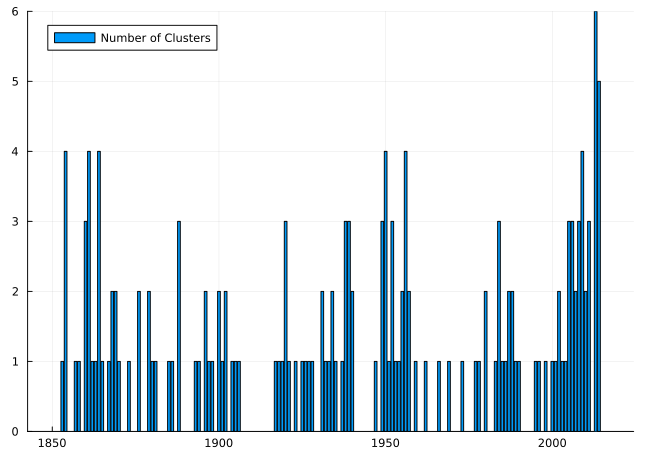

In [13]:
temp_decluster.Year = year.(temp_decluster.Day)
temp_count = combine(groupby(temp_decluster, :Year), nrow)
bar(temp_count.Year, temp_count.nrow, label="Number of Clusters")

Visually, it appears as though there has been an uptick in the number of
clusters post-2000, with more years containing 3+ clusters. This would
be hard to pull out without a model that depends on a broader warming
signal, since the most of the data record looks stationary, so it’s
unclear whether this is actually a trend. As a result, we might use
stationary Poisson process for the occurrences, or we could try to fit
one that was based on a covariate like global mean temperature.

Let’s now fit a stationary GPD to see what how the distribution of
conditional exceedances looks.

In [14]:
temp_exceedances = temp_high.TempMax .- 28
gpd_fit = Optim.optimize(p -> -sum(logpdf(GeneralizedPareto(0.0, p[1], p[2]), temp_exceedances)), [0.0, -Inf], [Inf, Inf], [1.0, 1.0]).minimizer

2-element Vector{Float64}:
  0.8510410229663868
 -0.18775785232439562

Let’s visualize this distribution
(<a href="#fig-gpd-fit" class="quarto-xref">Figure 3</a>) and also use a
Q-Q plot (<a href="#fig-qq-temp" class="quarto-xref">Figure 4</a>) to
see how well if fits the data.

In [15]:
plot(GeneralizedPareto(0.0, gpd_fit[1], gpd_fit[2]) .+ 28)

In [16]:
qqplot(GeneralizedPareto(0.0, gpd_fit[1], gpd_fit[2]), temp_exceedances, xlabel="Theoretical Quantile", ylabel="Empirical Quantile")

The fit looks generally good, though the tail of the data may be
slightly thinner (“less extreme” extremes) than the GPD fit implies (as
there is basically no fitted probability of exceedances at or above
31°C).

### Problem 4

<span style="color:red;">GRADED FOR 5850 STUDENTS ONLY</span>

In class, we modeled the annual maxima of the San Francisco tide gauge
data using a stationary GEV distribution. We could also hypothesize that
the tide extremes are influenced by the [Pacific Decadal Oscillation
(PDO)](https://en.wikipedia.org/wiki/Pacific_decadal_oscillation), which
is a climate pattern related to the sea-surface temperatures in the
Pacific Ocean (similar to the El Niño-Southern Oscillation), in the
following fashion (where only the GEV location is variable):

$$y_t \sim \text{GEV}(\mu_0 + \mu_1 p_t, \sigma, \xi)$$

**In this problem**:

-   Load the San Francisco tide gauge data (`data/h551.csv`) and the PDO
    index dataset (`data/errst.v5.pdo.dat`; this file is a
    space-delimited file, versus the comma-delimited `.csv` files, which
    can be loaded in Julia with
    `CSV.read(data/errst.v5.pdo.dat, DataFrame; delim=" ", header=2, ignorerepeated=true)`).
    The PDO data is given as monthly values; convert these to yearly
    indices by taking the mean. You should also drop 2023 due to the
    incomplete record. You can use the function at the bottom of these
    instructions to load the data, or adapt accordingly to a different
    language.
-   Find the MLE of the non-stationary GEV model and for a stationary
    GEV (constant $\mu$; we did this in class).
-   Discuss the difference(s) between the two fitted models based on the
    coefficient values (you can also bring to bear the range(s) of PDO
    values from the data), the 100- and 500-year return periods in 2022,
    and plotted hindcasts.

In [17]:
## load the data from the file and return a DataFrame of DateTime values and gauge measurements

function load_pdo(fname)
    # This uses the DataFramesMeta.jl package, which makes it easy to string together commands to load and process data
    df = DataFrame(CSVFiles.load(File(format"CSV", fname), spacedelim=true, skiplines_begin=1))
    # take yearly average
    @transform!(df, :PDO = mean(AsTable(names(df)[2:13])))
    @select!(df, $[:Year, :PDO])
    @rsubset!(df, :Year != 2023)
    return df
end

pdo = load_pdo("data/ersst.v5.pdo.dat")
# subset for years that match the tide gauge data
years = pdo[!, :Year]
@rsubset!(pdo, :Year in years)

***Solution***:

We have loaded the PDO data above, now let’s load the tide gauge data

In [18]:
# read in data and get annual maxima
function load_data(fname)
    date_format = DateFormat("yyyy-mm-dd HH:MM:SS")
    df = DataFrame(CSVFiles.load(fname, header_exists=false))
    rename!(df, "Column1" => "year", "Column2" => "month", "Column3" => "day", "Column4" => "hour", "Column5" => "gauge")
        # need to reformat the decimal date in the data file
    transform!(df, [:year, :month, :day, :hour] => ByRow(DateTime) => :datetime)
    # replace -99999 with missing
    df.gauge = ifelse.(abs.(df.gauge) .>= 9999, missing, df.gauge)
    select!(df, [:datetime, :gauge])
    return df
end

dat = load_data("data/h551.csv")
# detrend the data to remove the effects of sea-level rise and seasonal dynamics
ma_length = 366
ma_offset = Int(floor(ma_length/2))
moving_average(series,n) = [mean(@view series[i-n:i+n]) for i in n+1:length(series)-n]
dat_ma = DataFrame(datetime=dat.datetime[ma_offset+1:end-ma_offset], residual=dat.gauge[ma_offset+1:end-ma_offset] .- moving_average(dat.gauge, ma_offset))

# group data by year and compute the annual maxima
dat_ma = dropmissing(dat_ma) # drop missing data
dat_annmax = combine(dat_ma -> dat_ma[argmax(dat_ma.residual), :], groupby(transform(dat_ma, :datetime => x->year.(x)), :datetime_function))
delete!(dat_annmax, nrow(dat_annmax)) # delete 2023; haven't seen much of that year yet
rename!(dat_annmax, :datetime_function => :Year)
select!(dat_annmax, [:Year, :residual])

Fitting the stationary GEV:

In [19]:
p_stat = Optim.optimize(p -> -sum(logpdf(GeneralizedExtremeValue(p[1], p[2], p[3]), dat_annmax.residual)), [1000.0, 0.0, -5.0], [2000.0, 100.0, 5.0], [1500.0, 50.0, 0.0]).minimizer

3-element Vector{Float64}:
 1258.70967275348
   56.26648203812787
    0.017193689777705953

The non-stationary GEV differs in that we need to specify a regression
model for the location, which involves an additional parameter. One key
consideration is the range of the covariate, which would influence what
reasonable ranges of $\mu_0$ and $\mu_1$ might be. Let’s plot the
distribution.

In [20]:
histogram(pdo.PDO, legend=false)

Now we need to select a subset of PDO data which aligns with the storm
surge years.

In [21]:
dat = leftjoin(dat_annmax, pdo, on="Year") # join data frames on time

Finally, we can set parameter ranges and optimize.

In [22]:
lb = [800.0, -100.0, 0.0, -5.0]
ub = [2000.0, 100.0, 20.0, 5.0]
p0 = [1000.0, 10.0, 1.0, 0.25]

p_nonstat = Optim.optimize(p -> -sum(logpdf.(GeneralizedExtremeValue.(p[1] .+ p[2] * dat.PDO, p[3], p[4]), dat.residual)), lb, ub, p0).minimizer

4-element Vector{Float64}:
 1198.088480280648
   -7.443921155047124
   19.99999999935508
    0.5570827788570579

The parameter differences between `p_stat` and `p_nonstat` are quite
striking. While the location parameter of the stationary GEV is 1258.71
can range between 1180.53 and 1214.73. The stationary model is also more
highly skewed (based on the scale parameter), while the non-stationary
model has a fatter tail (based on the shape parameter, which is more
positive).

To see what these parameter differences imply, let’s look at the 100-
and 500-year return levels for both models. To do that, we need to
create the model objects.

In [23]:
# set up models
gev_stat = GeneralizedExtremeValue(p_stat[1], p_stat[2], p_stat[3])
# notice that this is a vector of distributions
gev_nonstat = GeneralizedExtremeValue.(p_nonstat[1] .+ p_nonstat[2] * dat.PDO, p_nonstat[3], p_nonstat[4])

126-element Vector{GeneralizedExtremeValue{Float64}}:
 GeneralizedExtremeValue{Float64}(μ=1197.0401280513122, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1197.393714306177, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1200.7062592201728, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1192.0837172155766, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1199.4718089619607, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1188.994489936232, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1195.9917758219763, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1189.4535317407933, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1187.7972592837953, σ=19.99999999935508, ξ=0.5570827788570579)
 GeneralizedExtremeValue{Float64}(μ=1192.0527008774304, σ

For the stationary model, these are the same every year as the model
does not change; the 100-year return level is the 0.99 quantile, which
is 1528.06 and the 500-year return level is the 0.998 quantile, which is
1627.69. For the non-stationary model, we need to look at this for a
given year; we’ll use 2022. In that case, the 100-year return level is
1643.58 and the 500-year return level is 2321.91. The more positive
shape parameter for the nonstationary model means that these return
levels are much more extreme.

Let’s look at hindcasts from the two models.

In [24]:
# set up models
gev_stat = GeneralizedExtremeValue(p_stat[1], p_stat[2], p_stat[3])
# notice that this is a vector of distributions
gev_nonstat = GeneralizedExtremeValue.(p_nonstat[1] .+ p_nonstat[2] * dat.PDO, p_nonstat[3], p_nonstat[4])

# simulate from the models
n_sample = 10_000
sim_stat = rand(gev_stat, (n_sample, nrow(dat)))
sim_nonstat = zeros(n_sample, nrow(dat))
for i in 1:nrow(dat)
    sim_nonstat[:, i] = rand(gev_nonstat[i], n_sample)
end

# compute quantiles
q_stat = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), sim_stat, dims=1)
q_nonstat = mapslices(col -> quantile(col, [0.025, 0.5, 0.975]), sim_nonstat, dims=1)

# make plot
plot(dat.Year, q_stat[2, :], ribbon=(q_stat[2, :] - q_stat[1, :], q_stat[3, :] - q_stat[2, :]), color=:blue, fillalpha=0.3, label="Stationary Model", legend=:topleft)
plot!(dat.Year, q_nonstat[2, :], ribbon=(q_nonstat[2, :] - q_nonstat[1, :], q_nonstat[3, :] - q_nonstat[2, :]), color=:green, fillalpha=0.3, label="Nonstationary Model")
scatter!(dat.Year, dat.residual, label="Data", color=:orange)
xlabel!("Year")
ylabel!("Annual Extreme Gauge Level (mm)")

We can see from <a href="#fig-pdo-hind" class="quarto-xref">Figure 6</a>
that the nonstationary model seems to capture some of the lower extremes
better, but neither model captures the very extreme values between 1980
and 2010. In general, we might be able to say that the nonstationary
model can be more flexible and account for variability in the data that
might throw off the calibration of a stationary model, but that
flexibility can be a blessing and a curse — if the covariate does not
actually explain meaningful variability in the data, we might
misinterpret the results or engage in overfitting. We could make the
model even more flexible by making the scale and shape nonstationary,
but that would exacerbate these risks.